In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
import pickle

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


from matplotlib import cm
from skimage import data, img_as_float

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.stats import sem

In [2]:
debug = True #or 'False' when you do not want to debug

path = "/Users/sfiligoj/Desktop/SEM_all"
os.chdir(path)
# Load the dictionary back from the pickle file.
df = pickle.load(open( "save.p", "rb" ) )

In [3]:
# df.drop(df[df.scansize==276].index, inplace=True)
# df.drop(df[df.scansize==345].index, inplace=True)
# df.drop(df[df.scansize==414].index, inplace=True)
# df.drop(df[df.scansize==518].index, inplace=True)

# df.drop(df[df.scansize==638].index, inplace=True)
# df.drop(df[df.scansize==829].index, inplace=True)
# df.drop(df[df.scansize==1180].index, inplace=True)

df.drop(df[df.scansize==1660].index, inplace=True)
df.drop(df[df.scansize==2070].index, inplace=True)
df.drop(df[df.scansize==2760].index, inplace=True)

df.drop(df[df.scansize==3450].index, inplace=True)
df.drop(df[df.scansize==4140].index, inplace=True)
df.drop(df[df.scansize==4830].index, inplace=True)

df.drop(df[df.scansize==5180].index, inplace=True)
df.drop(df[df.scansize==6380].index, inplace=True)
df.drop(df[df.scansize==8290].index, inplace=True)


df.drop(df[df.scansize==11800].index, inplace=True)
df.drop(df[df.scansize==16600].index, inplace=True)
df.drop(df[df.scansize==20700].index, inplace=True)
df.drop(df[df.scansize==82900].index, inplace=True)

In [4]:
df['px_size'] = df.scansize / df.n_pix
df['x_delta'] = [np.arange(px_size, scan_size+px_size, px_size) 
                     for px_size, scan_size in zip(df.px_size, df.scansize)] 
# we take the minimun px_size, and interpolate all HHcorr at x values whose delta is that minimum
min_dx = min(df.px_size)
# min_scansize = min(df.scansize)
min_scansize = 518
if debug: print(min_dx, min_scansize)
x_new = np.arange(min_dx, min_scansize, min_dx) # su quali x vogliamo l'interpolazione di HHcorr
# x = np.linspace(0, 2*np.pi, 10) # sara' il nostro Xdelta originale
# y = np.sin(x) # sara' il nostro HHcorr originale
# yinterp = np.interp(x_new, xdelta, HHcorr)

df

0.26953125 518


,filename,density,temp,hhcorr,scansize,n_pix,px_size,x_delta
0,H_asdep_006.tif,H,25,"[32176324.873505574, 34862881.42919412, 358437...",345,1024,0.336914,"[0.3369140625, 0.673828125, 1.0107421875, 1.34..."
1,Ru_LH_500C_015.tif,LH,500,"[30971148.212057844, 39822527.95124445, 495364...",829,1024,0.80957,"[0.8095703125, 1.619140625, 2.4287109375, 3.23..."
2,Ru_LH_700C_077.tif,LH,700,"[9848706.73064116, 10840572.095596174, 1142325...",414,1024,0.404297,"[0.404296875, 0.80859375, 1.212890625, 1.61718..."
4,H_700C_024.tif,H,700,"[30515781.720810007, 33113456.48294899, 340378...",518,1024,0.505859,"[0.505859375, 1.01171875, 1.517578125, 2.02343..."
5,H_700C_1um_047.tif,H,700,"[37770678.785245955, 43465627.65496086, 478992...",1180,1024,1.15234,"[1.15234375, 2.3046875, 3.45703125, 4.609375, ..."
...,...,...,...,...,...,...,...,...
143,Ru_LH_700C_090.tif,LH,700,"[13131190.219944142, 17982814.999097284, 24234...",1180,1024,1.15234,"[1.15234375, 2.3046875, 3.45703125, 4.609375, ..."
144,Ru_LH_800C_026.tif,LH,800,"[7328231.583817692, 9188410.093843581, 1145587...",518,1024,0.505859,"[0.505859375, 1.01171875, 1.517578125, 2.02343..."
147,Ru_LH_800C_033.tif,LH,800,"[12565847.287315503, 21418237.29229967, 335554...",1180,1024,1.15234,"[1.15234375, 2.3046875, 3.45703125, 4.609375, ..."
148,Ru_LH_800C_027.tif,LH,800,"[8141302.405999338, 9122066.375893166, 9837509...",345,1024,0.336914,"[0.3369140625, 0.673828125, 1.0107421875, 1.34..."


In [5]:
# we create Xdelta for each row, all at once


In [6]:
#definition of HHcorr-interpolated:
df['hhcorr_interp'] = [np.interp(x_new, x, y) for x,y in zip(df.x_delta, df.hhcorr)]

In [20]:
# AvHHcorr blueprint -> AvHHcorr[density][temperature] = average of all HHcorr for that selection
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()

AvHHcorr = {} 
for dens in densities:
    AvHHcorr[dens] = {}
    for temp in temperatures:
        AvHHcorr[dens][temp] = {}
        # create the selection
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        # we take the interpolated HHcorr from the "selection" DataFrame
        # we create a matrix, where each HHcorr array from a different measurement is a full row
        # when we average on the columns, we get the average_HHcorr
        all_hhcorr = np.matrix(selection.hhcorr_interp.tolist()) 
        AvHHcorr[dens][temp]['value'] = np.ravel(all_hhcorr.mean(axis = 0))
        AvHHcorr[dens][temp]['HH_0'] = AvHHcorr[dens][temp]['value'][0]
        err = np.ravel(sem(all_hhcorr, axis = 0))
        AvHHcorr[dens][temp]['err']   = err
        AvHHcorr[dens][temp]['value_upper'] = AvHHcorr[dens][temp]['value'] + err
        AvHHcorr[dens][temp]['value_lower'] = AvHHcorr[dens][temp]['value'] - err
        
        
# #*** per ricordarmi cosa ho fatto prima:
# cosa = df[df.temp==t].hhcorr_interp
# sm = np.matrix(cosa.tolist())
# i=0
# temp = sm[:,i] # gli i-esimi elementi di ogni HHcorr del tuo df iniziale
# print(np.std(temp))

In [27]:
# *** Calculate average HHcorr from interpolated values, and the associated standard deviation
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()

row={}
df2 = pd.DataFrame(
        columns= ['density','temp', 'avhhcorr','xdelta','HH_0'])

for dens in densities:
    row[dens] = {}
    for temp in temperatures:
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        row[dens][temp] = {}
        #crei la riga:
        row[dens][temp]['density'] = dens
        row[dens][temp]['temperature'] = temp
        row[dens][temp]['avHHcorr'] = AvHHcorr[dens][temp]['value']
        row[dens][temp]['HH_0'] = AvHHcorr[dens][temp]['HH_0'] 

        # # *** Create new dataframe for the calculation of CorrLen and Alpha on this data:
        df2 = df2.append( 
                {'density': row[dens][temp]['density'],
                 'temp': row[dens][temp]['temperature'],  
                 'avhhcorr': row[dens][temp]['avHHcorr'], 
                 'xdelta': x_new,
                 'HH_0': row[dens][temp]['HH_0']
                },
                ignore_index=True)
pickle.dump(df2, open( "AvHHcorr_interpolated.p", "wb" ) )
df2

,density,temp,avhhcorr,xdelta,HH_0
0,H,25,"[32636348.909432653, 33217039.580138117, 34321...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",3.263635e+07
1,H,250,"[57681619.85248088, 59061740.77626527, 6149876...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",5.768162e+07
2,H,500,"[35490628.96112427, 35521509.496070616, 359159...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",3.549063e+07
3,H,600,"[56163265.56507907, 56163265.56507907, 5616326...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",5.616327e+07
4,H,700,"[36104465.33193943, 36123410.19292457, 3639024...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",3.610447e+07
5,H,800,"[24490890.75503886, 24516778.990800653, 247269...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",2.449089e+07
6,LH,25,"[38752413.717496686, 39264380.04743566, 406203...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",3.875241e+07
7,LH,250,"[38358163.24644481, 38680011.57586556, 3970881...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",3.835816e+07
8,LH,500,"[30721043.26080183, 31098872.933731668, 323147...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",3.072104e+07
9,LH,600,"[27680309.272425152, 27908558.437230676, 28619...","[0.26953125, 0.5390625, 0.80859375, 1.078125, ...",2.768031e+07


In [70]:
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()

# blueprint -> minHH_0[density] = value (later, we will subtract this value to each HH_corr)
minHH_0 = {}
adj_hhcorr = {}

for d in densities:
    adj_hhcorr[d]={}
    
    slctn = df2[df2.density==d]   
    minHH_0 = min(slctn.HH_0)
    
    for t in temperatures:
        adj_hhcorr[d][t]={}
        
        if AvHHcorr[d][t]['value'][0] == minHH_0:
            adj_hhcorr[d][t]['value'] = AvHHcorr[d][t]['value'] # copying it
        
        else:
            offset = AvHHcorr[d][t]['value'][0]-minHH_0
            adj_hhcorr[d][t]['value'] = AvHHcorr[d][t]['value'] - offset


<IPython.core.display.Javascript object>


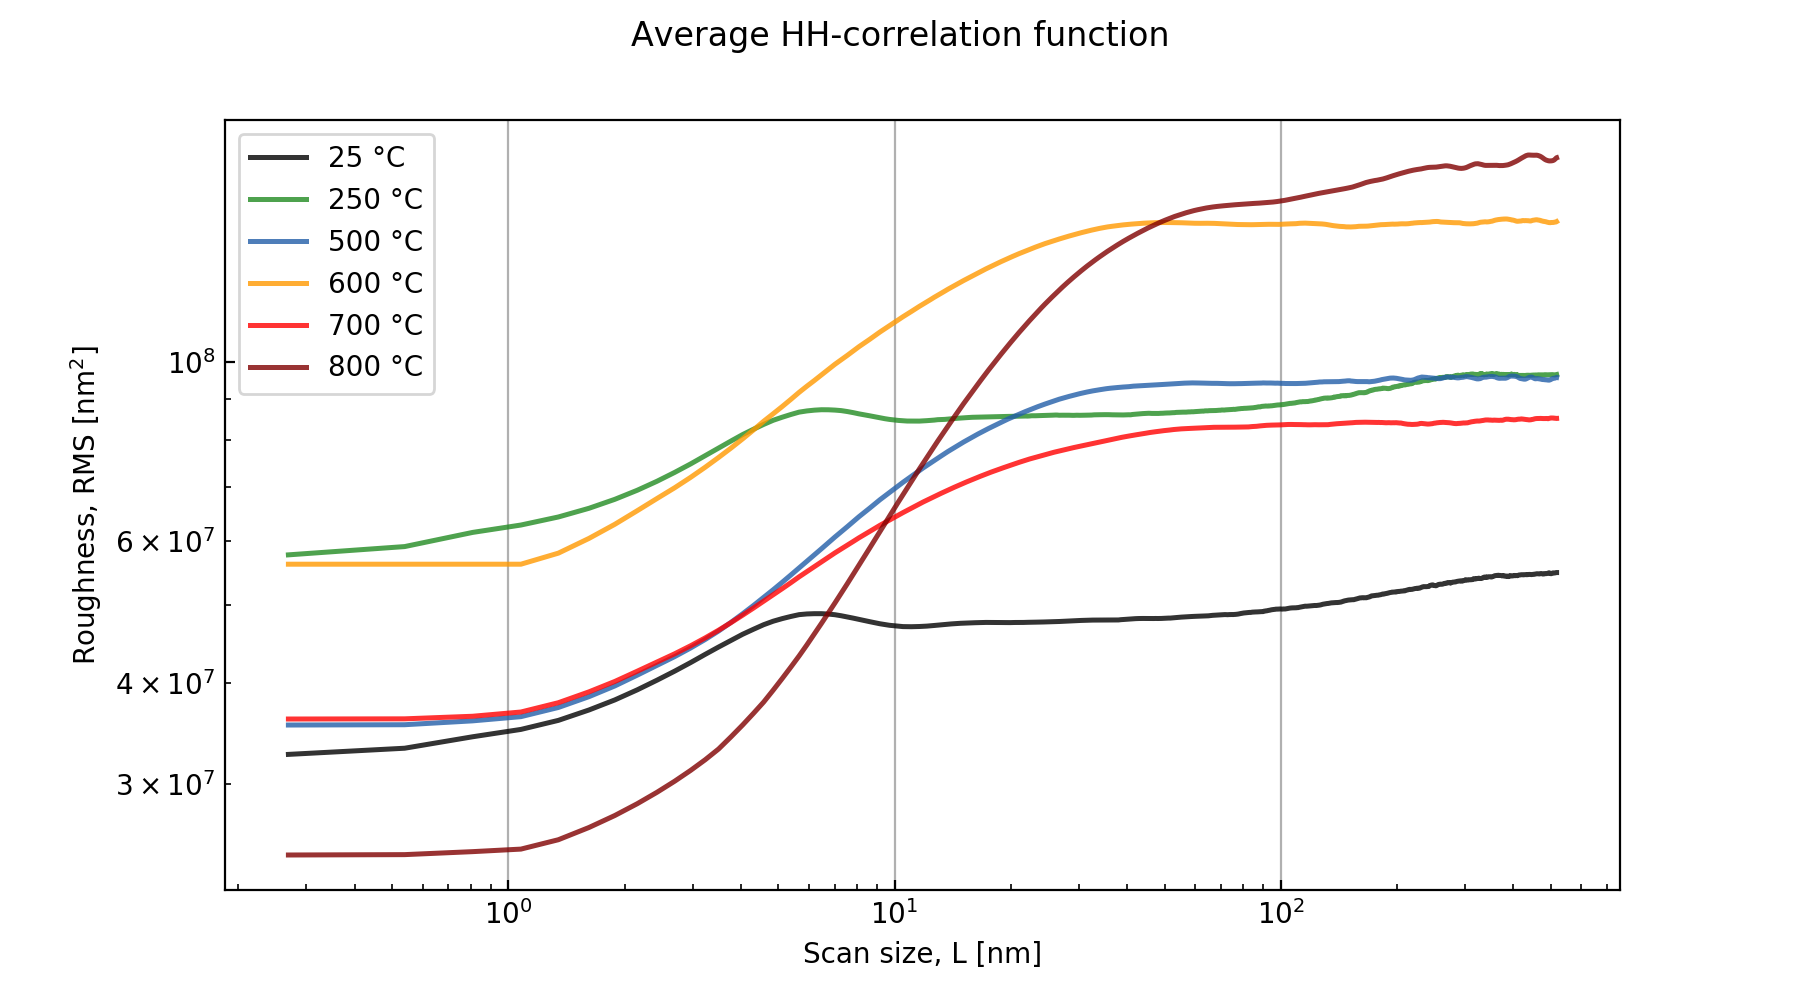

In [74]:
# *** Plot everything in one graph:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250','500','600','700','800']
colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    
    density = 'H'
    
    label = f"{temp} °C"
    ax.loglog(
        x_new[:],
        AvHHcorr[density][temp]['value'][:],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )

#     ax.scatter(x_new[4], AvHHcorr[temp]['value'][4], c='darkblue', s=5, zorder=10)
    label = None
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Roughness, RMS [nm$^2$]')
ax.set(xlabel='Scan size, L [nm]')
titl = f"Average HH-correlation function"
fig.suptitle(titl)

# figname = f"{titl}.png"
# fig.savefig(f'Average HH function_interpolated - Low density Ru(500nm).png', dpi=600)


ax.xaxis.grid() # vertical lines


<IPython.core.display.Javascript object>


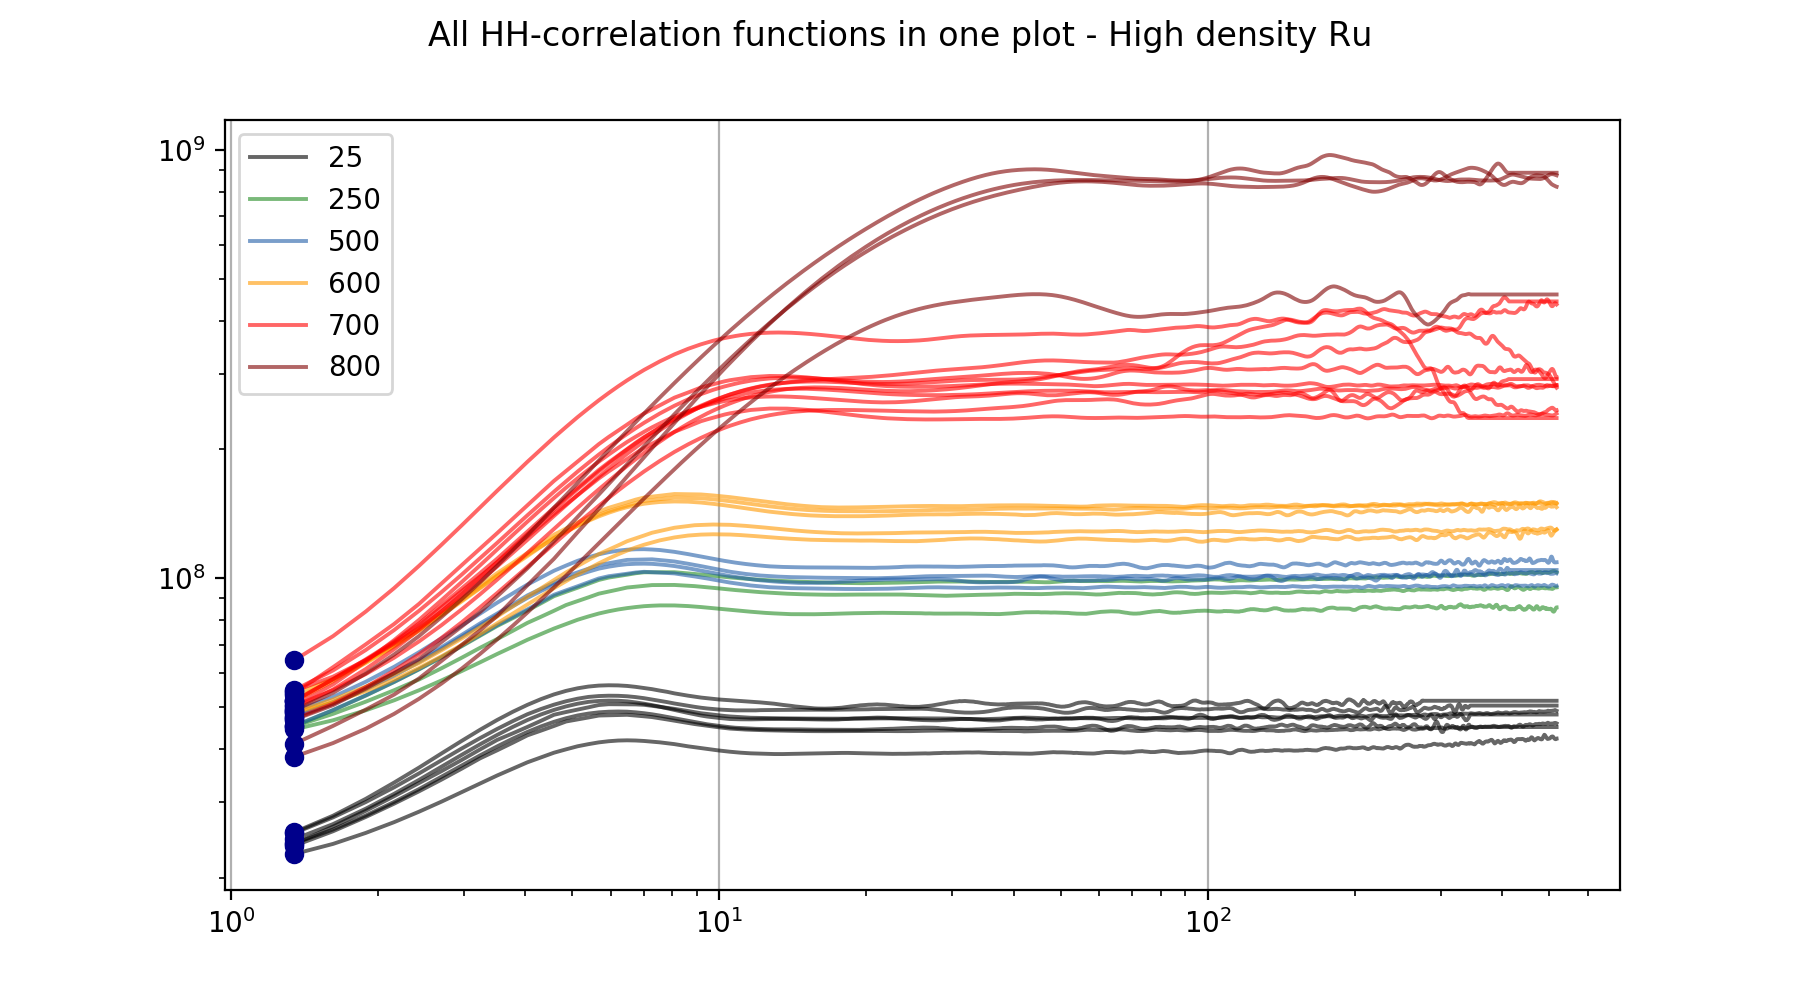

In [73]:
# *** If I want to see each single HHcorr function (interpolated but not averaged)
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250','500','600','700','800']
colors = ['black','forestgreen', '#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    selection = df[df.temp==temp]
    selection = selection[selection.density=='L']
    label = temp
    for idx, row in selection.iterrows():
        ax.loglog(
            x_new[4:],
            row.hhcorr_interp[4:],
            c = color,
            alpha = 0.6,
            linewidth = 1.4,
            label = label
        )
        ax.scatter(x_new[4], row.hhcorr_interp[4], c='darkblue', zorder=10)
        label = None
ax.legend()
titl = f"All HH-correlation functions in one plot - High density Ru"
fig.suptitle(titl)
ax.xaxis.grid() # vertical lines
# figname = f"{titl}.png"
# fig.savefig(f'Average HH function - Low density Ru.png', dpi=600)



In [ ]:
# *** to visualize error
fig, ax  = plt.subplots()
ax.plot(
    x_new,
    AvHHcorr[t]['value'],
)
ax.plot(
    x_new,
    AvHHcorr[t]['value_lower'],
)
ax.plot(
    x_new,
    AvHHcorr[t]['value_upper'],
)